In [1]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay, auc, log_loss, recall_score, f1_score, precision_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


# Persiapan Data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Data Science/1. Telco Customer Churn/Data/TelcoChurn_prep.csv")

In [5]:
df = df.drop(["customerID"],axis=1)

In [6]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

In [7]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [8]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)

In [9]:
selector = SelectKBest(score_func=f_classif, k=10)
X_train_res_sel = selector.fit_transform(X_train_res, y_train_res)
X_test_sel = selector.transform(X_test_sm)

In [10]:
selected_features = selector.get_feature_names_out(input_features=X.columns)

X_train_res_sel_df = pd.DataFrame(X_train_res_sel, columns=selected_features)
X_test_sel_df = pd.DataFrame(X_test_sel, columns=selected_features)

In [11]:
pca = PCA(n_components=5)
X_train_res_pca = pca.fit_transform(X_train_res_sel)
X_test_pca = pca.transform(X_test_sel)

In [12]:
X_train_res_pca_df = pd.DataFrame(X_train_res_pca, columns=[f'PC{i+1}' for i in range(X_train_res_pca.shape[1])])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Baseline Model

In [13]:
rf = RandomForestClassifier(random_state=42)

In [14]:
rf.fit(X_train_res_pca_df, y_train_res)

RandomForestClassifier(random_state=42)

In [15]:
y_pred = rf.predict(X_test_pca_df)

In [16]:
print("Accuracy:", accuracy_score(y_test_sm, y_pred))
print("Precision:", precision_score(y_test_sm, y_pred))
print("Recall:", recall_score(y_test_sm, y_pred))
print("F1-score:", f1_score(y_test_sm, y_pred))
print("Confusion matriks: \n",confusion_matrix(y_test_sm, y_pred))
print(classification_report(y_test_sm, y_pred))

Accuracy: 0.7241706161137441
Precision: 0.4859437751004016
Recall: 0.6470588235294118
F1-score: 0.5550458715596331
Confusion matriks: 
 [[1165  384]
 [ 198  363]]
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      1549
           1       0.49      0.65      0.56       561

    accuracy                           0.72      2110
   macro avg       0.67      0.70      0.68      2110
weighted avg       0.76      0.72      0.73      2110



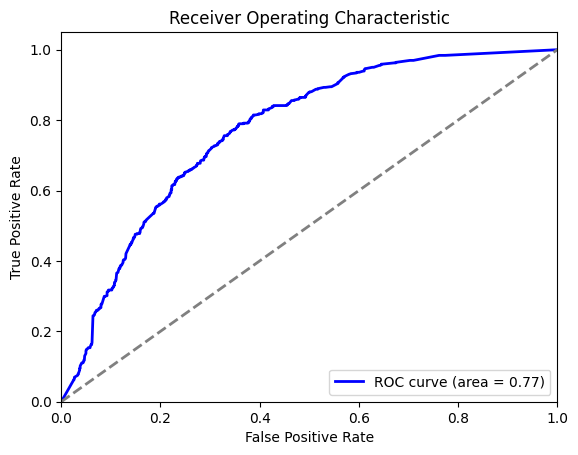

In [17]:
y_pred_proba = rf.predict_proba(X_test_pca_df)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_sm, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

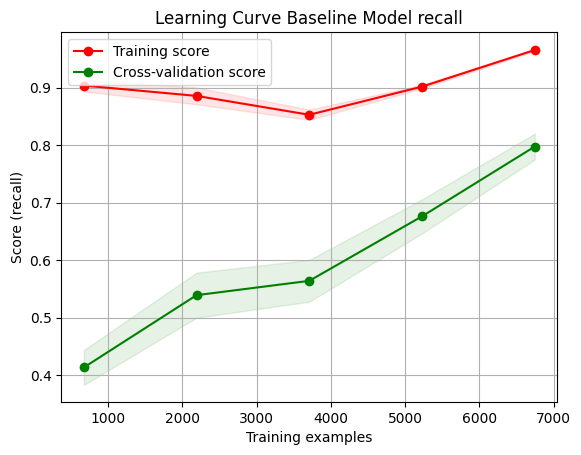

In [18]:
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(rf, X_train_res_pca_df, y_train_res, cv=cv, scoring='recall')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve Baseline Model recall")
plt.xlabel("Training examples")
plt.ylabel("Score (recall)")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Model Performance Curves

## max_depth

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>1, train recall: 0.745, test recall: 0.725
>1, train f1: 0.749, test f1: 0.602
Recall Rentang adalah = 0.020
F1 Rentang adalah = 0.147




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>2, train recall: 0.761, test recall: 0.729
>2, train f1: 0.758, test f1: 0.602
Recall Rentang adalah = 0.032
F1 Rentang adalah = 0.157




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>3, train recall: 0.783, test recall: 0.758
>3, train f1: 0.769, test f1: 0.615
Recall Rentang adalah = 0.026
F1 Rentang adalah = 0.153




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>4, train recall: 0.794, test recall: 0.758
>4, train f1: 0.776, test f1: 0.615
Recall Rentang adalah = 0.036
F1 Rentang adalah = 0.161




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>5, train recall: 0.811, test recall: 0.754
>5, train f1: 0.785, test f1: 0.607
Recall Rentang adalah = 0.057
F1 Rentang adalah = 0.178




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>6, train recall: 0.827, test recall: 0.766
>6, train f1: 0.793, test f1: 0.609
Recall Rentang adalah = 0.060
F1 Rentang adalah = 0.184




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>7, train recall: 0.832, test recall: 0.768
>7, train f1: 0.799, test f1: 0.611
Recall Rentang adalah = 0.064
F1 Rentang adalah = 0.188




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>8, train recall: 0.838, test recall: 0.754
>8, train f1: 0.802, test f1: 0.604
Recall Rentang adalah = 0.084
F1 Rentang adalah = 0.198




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>9, train recall: 0.844, test recall: 0.733
>9, train f1: 0.808, test f1: 0.599
Recall Rentang adalah = 0.111
F1 Rentang adalah = 0.209




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>10, train recall: 0.844, test recall: 0.722
>10, train f1: 0.810, test f1: 0.591
Recall Rentang adalah = 0.122
F1 Rentang adalah = 0.219




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>11, train recall: 0.842, test recall: 0.715
>11, train f1: 0.810, test f1: 0.590
Recall Rentang adalah = 0.127
F1 Rentang adalah = 0.220




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>12, train recall: 0.840, test recall: 0.713
>12, train f1: 0.809, test f1: 0.587
Recall Rentang adalah = 0.127
F1 Rentang adalah = 0.222




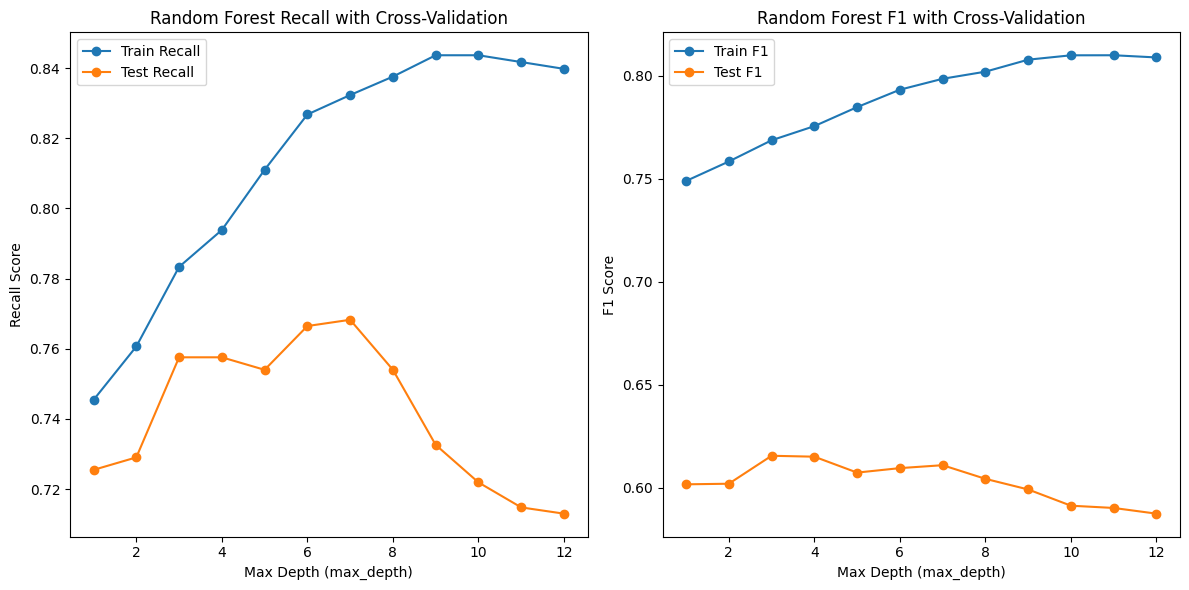

In [19]:
values = [i for i in range(1, 13)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

for i in values:
    model = RandomForestClassifier(max_depth=i, random_state=42, n_jobs=-1)

    train_recalls_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca_df, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("Max Depth (max_depth)")
plt.ylabel("Recall Score")
plt.legend()
plt.title("Random Forest Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("Max Depth (max_depth)")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Random Forest F1 with Cross-Validation")

plt.tight_layout()
plt.show()

- Dari grafik, ada indikasi bahwa model mulai overfitting setelah max_depth 7-8

- Untuk menghindari overfitting, kita akan memilih nilai max_depth yang lebih rendah. Dari grafik, max_depth sekitar 5-7 tampaknya memberikan keseimbangan yang baik antara recall dan F1 score pada data uji.


## min_samples_split

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>2, train recall: 0.797, test recall: 0.647
>2, train f1: 0.791, test f1: 0.555
Recall Rentang adalah = 0.150
F1 Rentang adalah = 0.236




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>3, train recall: 0.800, test recall: 0.647
>3, train f1: 0.793, test f1: 0.553
Recall Rentang adalah = 0.153
F1 Rentang adalah = 0.239




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>4, train recall: 0.803, test recall: 0.651
>4, train f1: 0.794, test f1: 0.555
Recall Rentang adalah = 0.152
F1 Rentang adalah = 0.239




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>5, train recall: 0.805, test recall: 0.660
>5, train f1: 0.795, test f1: 0.561
Recall Rentang adalah = 0.146
F1 Rentang adalah = 0.234




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>6, train recall: 0.810, test recall: 0.670
>6, train f1: 0.799, test f1: 0.560
Recall Rentang adalah = 0.140
F1 Rentang adalah = 0.239




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>7, train recall: 0.811, test recall: 0.677
>7, train f1: 0.798, test f1: 0.571
Recall Rentang adalah = 0.134
F1 Rentang adalah = 0.227




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>8, train recall: 0.815, test recall: 0.684
>8, train f1: 0.800, test f1: 0.573
Recall Rentang adalah = 0.131
F1 Rentang adalah = 0.227




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>9, train recall: 0.815, test recall: 0.695
>9, train f1: 0.800, test f1: 0.583
Recall Rentang adalah = 0.120
F1 Rentang adalah = 0.217




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>10, train recall: 0.820, test recall: 0.688
>10, train f1: 0.804, test f1: 0.580
Recall Rentang adalah = 0.132
F1 Rentang adalah = 0.224




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>11, train recall: 0.817, test recall: 0.686
>11, train f1: 0.801, test f1: 0.580
Recall Rentang adalah = 0.131
F1 Rentang adalah = 0.221




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>12, train recall: 0.822, test recall: 0.690
>12, train f1: 0.804, test f1: 0.579
Recall Rentang adalah = 0.132
F1 Rentang adalah = 0.225




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>13, train recall: 0.822, test recall: 0.693
>13, train f1: 0.804, test f1: 0.585
Recall Rentang adalah = 0.128
F1 Rentang adalah = 0.219




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>14, train recall: 0.822, test recall: 0.688
>14, train f1: 0.804, test f1: 0.580
Recall Rentang adalah = 0.134
F1 Rentang adalah = 0.225




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>15, train recall: 0.823, test recall: 0.693
>15, train f1: 0.804, test f1: 0.582
Recall Rentang adalah = 0.130
F1 Rentang adalah = 0.222




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>16, train recall: 0.825, test recall: 0.695
>16, train f1: 0.805, test f1: 0.585
Recall Rentang adalah = 0.130
F1 Rentang adalah = 0.220




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>17, train recall: 0.828, test recall: 0.695
>17, train f1: 0.805, test f1: 0.584
Recall Rentang adalah = 0.132
F1 Rentang adalah = 0.221




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>18, train recall: 0.825, test recall: 0.704
>18, train f1: 0.804, test f1: 0.591
Recall Rentang adalah = 0.121
F1 Rentang adalah = 0.213




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>19, train recall: 0.826, test recall: 0.704
>19, train f1: 0.804, test f1: 0.594
Recall Rentang adalah = 0.122
F1 Rentang adalah = 0.211




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>20, train recall: 0.828, test recall: 0.699
>20, train f1: 0.807, test f1: 0.589
Recall Rentang adalah = 0.130
F1 Rentang adalah = 0.217




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>21, train recall: 0.830, test recall: 0.711
>21, train f1: 0.808, test f1: 0.596
Recall Rentang adalah = 0.119
F1 Rentang adalah = 0.213




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>22, train recall: 0.828, test recall: 0.695
>22, train f1: 0.805, test f1: 0.586
Recall Rentang adalah = 0.132
F1 Rentang adalah = 0.219




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>23, train recall: 0.830, test recall: 0.702
>23, train f1: 0.806, test f1: 0.592
Recall Rentang adalah = 0.128
F1 Rentang adalah = 0.214




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>24, train recall: 0.831, test recall: 0.704
>24, train f1: 0.806, test f1: 0.593
Recall Rentang adalah = 0.127
F1 Rentang adalah = 0.213




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>25, train recall: 0.828, test recall: 0.697
>25, train f1: 0.805, test f1: 0.590
Recall Rentang adalah = 0.131
F1 Rentang adalah = 0.215




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>26, train recall: 0.828, test recall: 0.702
>26, train f1: 0.805, test f1: 0.593
Recall Rentang adalah = 0.126
F1 Rentang adalah = 0.212




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>27, train recall: 0.827, test recall: 0.699
>27, train f1: 0.804, test f1: 0.591
Recall Rentang adalah = 0.128
F1 Rentang adalah = 0.213




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>28, train recall: 0.829, test recall: 0.706
>28, train f1: 0.805, test f1: 0.593
Recall Rentang adalah = 0.123
F1 Rentang adalah = 0.212




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>29, train recall: 0.830, test recall: 0.717
>29, train f1: 0.806, test f1: 0.600
Recall Rentang adalah = 0.114
F1 Rentang adalah = 0.206




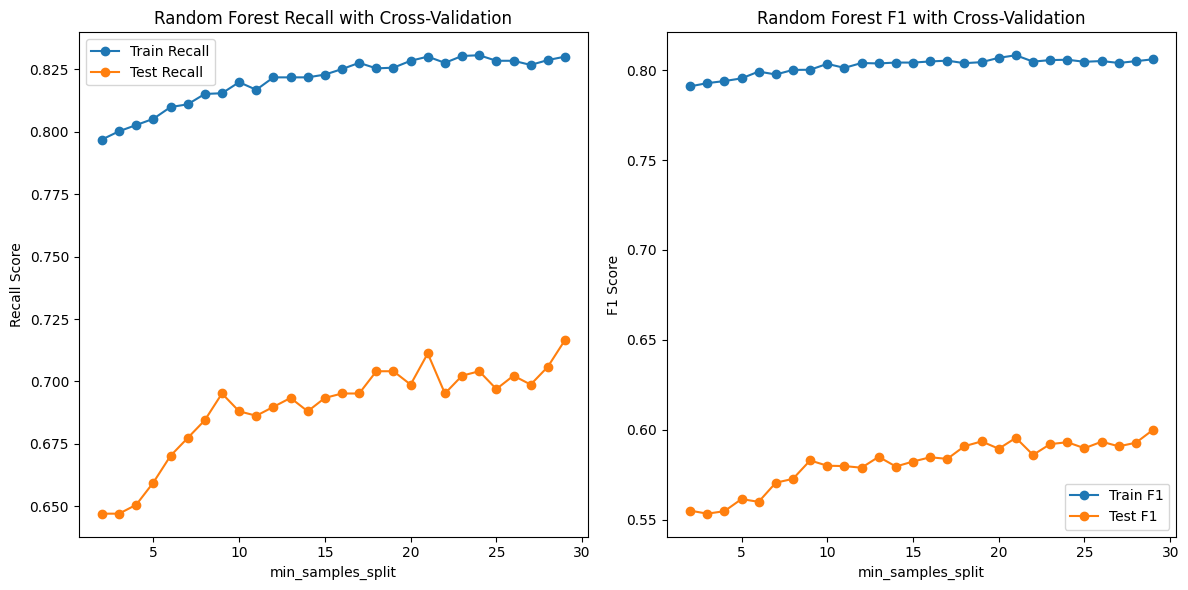

In [20]:
values = [i for i in range(2, 30)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

for i in values:
    model = RandomForestClassifier(min_samples_split=i, n_jobs=-1, random_state=42)

    train_recalls_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca_df, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("min_samples_split")
plt.ylabel("Recall Score")
plt.legend()
plt.title("Random Forest Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("min_samples_split")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Random Forest F1 with Cross-Validation")

plt.tight_layout()
plt.show()

- Recall pada data pengujian mulai stabil dan mencapai nilai tertinggi sekitar nilai min_samples_split antara 10 hingga 20, Setelah nilai 20, recall cenderung tidak meningkat signifikan.

- F1 score pada data pengujian juga menunjukkan peningkatan yang konsisten hingga sekitar nilai min_samples_split antara 15 hingga 25, Setelah nilai 25, F1 score mulai menunjukkan stabilisasi dan sedikit fluktuasi.

- rentang paling bagus nampaknya 10 - 20

# min_samples_leaf

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>1, train recall: 0.797, test recall: 0.647
>1, train f1: 0.791, test f1: 0.555
Recall Rentang adalah = 0.150
F1 Rentang adalah = 0.236




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>2, train recall: 0.819, test recall: 0.684
>2, train f1: 0.801, test f1: 0.569
Recall Rentang adalah = 0.135
F1 Rentang adalah = 0.232




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>3, train recall: 0.827, test recall: 0.695
>3, train f1: 0.804, test f1: 0.581
Recall Rentang adalah = 0.131
F1 Rentang adalah = 0.223




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>4, train recall: 0.827, test recall: 0.709
>4, train f1: 0.803, test f1: 0.587
Recall Rentang adalah = 0.118
F1 Rentang adalah = 0.215




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>5, train recall: 0.831, test recall: 0.720
>5, train f1: 0.804, test f1: 0.594
Recall Rentang adalah = 0.111
F1 Rentang adalah = 0.210




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>6, train recall: 0.831, test recall: 0.727
>6, train f1: 0.804, test f1: 0.600
Recall Rentang adalah = 0.104
F1 Rentang adalah = 0.203




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>7, train recall: 0.835, test recall: 0.729
>7, train f1: 0.806, test f1: 0.598
Recall Rentang adalah = 0.106
F1 Rentang adalah = 0.208




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>8, train recall: 0.836, test recall: 0.727
>8, train f1: 0.806, test f1: 0.596
Recall Rentang adalah = 0.109
F1 Rentang adalah = 0.210




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>9, train recall: 0.835, test recall: 0.727
>9, train f1: 0.805, test f1: 0.601
Recall Rentang adalah = 0.108
F1 Rentang adalah = 0.204




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>10, train recall: 0.835, test recall: 0.738
>10, train f1: 0.804, test f1: 0.601
Recall Rentang adalah = 0.097
F1 Rentang adalah = 0.203




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>11, train recall: 0.833, test recall: 0.733
>11, train f1: 0.804, test f1: 0.604
Recall Rentang adalah = 0.101
F1 Rentang adalah = 0.200




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>12, train recall: 0.832, test recall: 0.729
>12, train f1: 0.805, test f1: 0.602
Recall Rentang adalah = 0.103
F1 Rentang adalah = 0.202




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>13, train recall: 0.831, test recall: 0.733
>13, train f1: 0.801, test f1: 0.599
Recall Rentang adalah = 0.098
F1 Rentang adalah = 0.202




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>14, train recall: 0.829, test recall: 0.729
>14, train f1: 0.802, test f1: 0.598
Recall Rentang adalah = 0.100
F1 Rentang adalah = 0.203




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>15, train recall: 0.829, test recall: 0.736
>15, train f1: 0.802, test f1: 0.602
Recall Rentang adalah = 0.093
F1 Rentang adalah = 0.201




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>16, train recall: 0.825, test recall: 0.733
>16, train f1: 0.799, test f1: 0.599
Recall Rentang adalah = 0.093
F1 Rentang adalah = 0.200




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>17, train recall: 0.825, test recall: 0.742
>17, train f1: 0.798, test f1: 0.605
Recall Rentang adalah = 0.083
F1 Rentang adalah = 0.193




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>18, train recall: 0.821, test recall: 0.740
>18, train f1: 0.795, test f1: 0.603
Recall Rentang adalah = 0.082
F1 Rentang adalah = 0.192




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


>19, train recall: 0.821, test recall: 0.734
>19, train f1: 0.797, test f1: 0.599
Recall Rentang adalah = 0.087
F1 Rentang adalah = 0.198




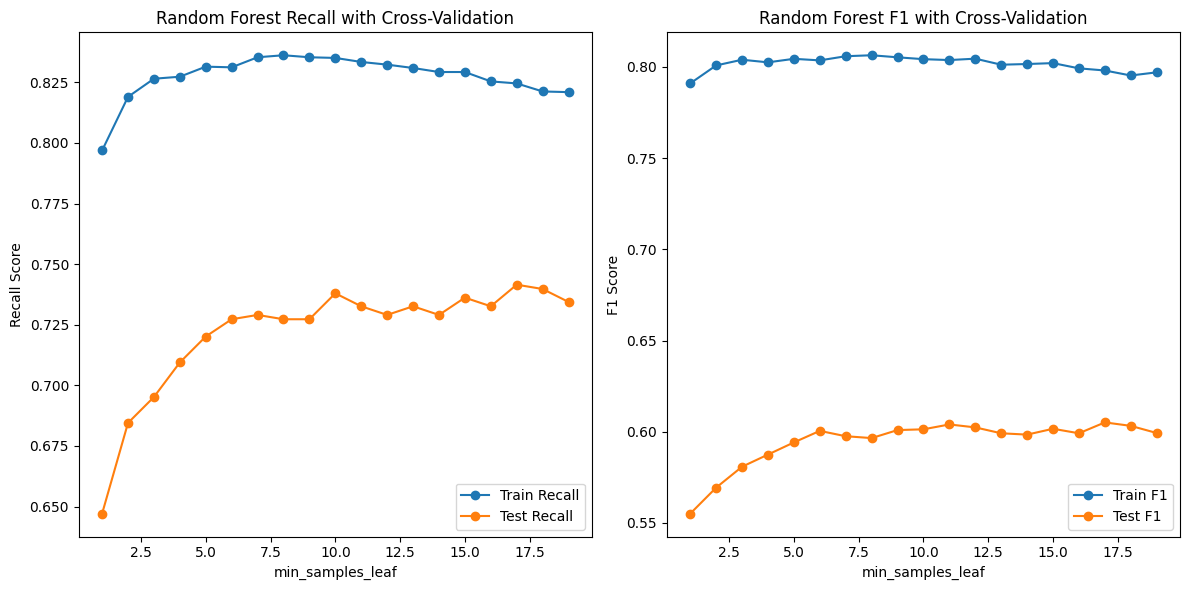

In [21]:
values = [i for i in range(1, 20)]
train_recalls, test_recalls = list(), list()
train_f1s, test_f1s = list(), list()

cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

for i in values:
    model = RandomForestClassifier(min_samples_leaf=i, n_jobs=-1, random_state=42)

    train_recalls_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="recall")
    train_recall = train_recalls_cv.mean()
    train_recalls.append(train_recall)

    train_f1s_cv = cross_val_score(model, X_train_res_pca_df, y_train_res, cv=cv, scoring="f1")
    train_f1 = train_f1s_cv.mean()
    train_f1s.append(train_f1)

    model.fit(X_train_res_pca_df, y_train_res)
    test_yhat = model.predict(X_test_pca)

    test_recall = recall_score(y_test_sm, test_yhat)
    test_recalls.append(test_recall)

    test_f1 = f1_score(y_test_sm, test_yhat)
    test_f1s.append(test_f1)

    print(">%d, train recall: %.3f, test recall: %.3f" % (i, train_recall, test_recall))
    print(">%d, train f1: %.3f, test f1: %.3f" % (i, train_f1, test_f1))
    recall_rentang = train_recall - test_recall
    f1_rentang = train_f1 - test_f1
    print(f"Recall Rentang adalah = {recall_rentang:.3f}")
    print(f"F1 Rentang adalah = {f1_rentang:.3f}")
    print("\n")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(values, train_recalls, "-o", label="Train Recall")
plt.plot(values, test_recalls, "-o", label="Test Recall")
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall Score")
plt.legend()
plt.title("Random Forest Recall with Cross-Validation")

plt.subplot(1, 2, 2)
plt.plot(values, train_f1s, "-o", label="Train F1")
plt.plot(values, test_f1s, "-o", label="Test F1")
plt.xlabel("min_samples_leaf")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Random Forest F1 with Cross-Validation")

plt.tight_layout()
plt.show()

- Recall pada data pengujian mulai stabil dan mencapai nilai tertinggi sekitar nilai min_samples_leaf antara 7 hingga 15.

# Hyperparameter Tunning

In [25]:
search_space = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': (5, 8),
    'min_samples_split': (10, 21),
    'min_samples_leaf': (7, 16),
    'bootstrap': [True, False]
}

In [26]:
rf = RandomForestClassifier(random_state=42)

In [27]:
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=search_space,
    n_iter=50,
    cv=cv,
    scoring='recall',
    random_state=42,
    n_jobs=-1
)

In [28]:
bayes_search.fit(X_train_res_pca_df, y_train_res)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [False, 8, 'sqrt', 7, 10, 200] before, using random point [True, 5, 'log2', 9, 17, 200]
  warnings.warn(


BayesSearchCV(cv=StratifiedKFold(n_splits=15, random_state=42, shuffle=True),
              estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
              random_state=42, scoring='recall',
              search_spaces={'bootstrap': [True, False], 'max_depth': (5, 8),
                             'max_features': ['sqrt', 'log2'],
                             'min_samples_leaf': (7, 16),
                             'min_samples_split': (10, 21),
                             'n_estimators': [100, 200, 300]})

In [29]:
best_params = bayes_search.best_params_
best_model = bayes_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: OrderedDict([('bootstrap', True), ('max_depth', 8), ('max_features', 'log2'), ('min_samples_leaf', 7), ('min_samples_split', 11), ('n_estimators', 300)])


# Evaluasi final model

In [30]:
rf = RandomForestClassifier(max_depth= 8,
                            min_samples_split= 11,
                            min_samples_leaf= 7,
                            max_features= "log2",
                            n_estimators= 300,
                            bootstrap= True,
                            random_state= 42,
                            n_jobs=-1)

In [31]:
rf.fit(X_train_res_pca_df, y_train_res)

RandomForestClassifier(max_depth=8, max_features='log2', min_samples_leaf=7,
                       min_samples_split=11, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [32]:
y_pred = rf.predict(X_test_pca_df)

In [33]:
print("Accuracy:", accuracy_score(y_test_sm, y_pred))
print("Precision:", precision_score(y_test_sm, y_pred))
print("Recall:", recall_score(y_test_sm, y_pred))
print("F1-score:", f1_score(y_test_sm, y_pred))
print("Confusion matriks: \n",confusion_matrix(y_test_sm, y_pred))
print(classification_report(y_test_sm, y_pred))

Accuracy: 0.7398104265402844
Precision: 0.5071599045346062
Recall: 0.7575757575757576
F1-score: 0.6075768406004289
Confusion matriks: 
 [[1136  413]
 [ 136  425]]
              precision    recall  f1-score   support

           0       0.89      0.73      0.81      1549
           1       0.51      0.76      0.61       561

    accuracy                           0.74      2110
   macro avg       0.70      0.75      0.71      2110
weighted avg       0.79      0.74      0.75      2110



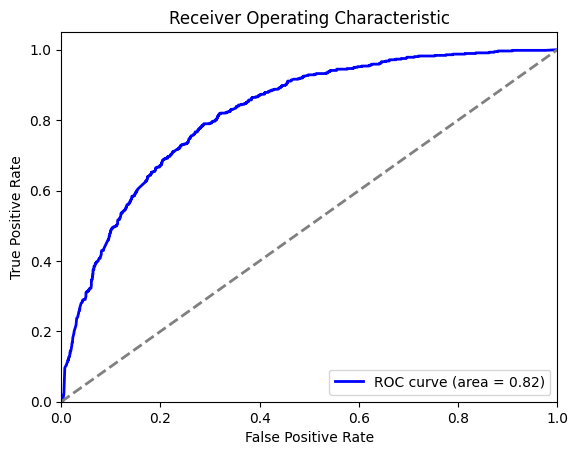

In [34]:
y_pred_proba = rf.predict_proba(X_test_pca_df)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_sm, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

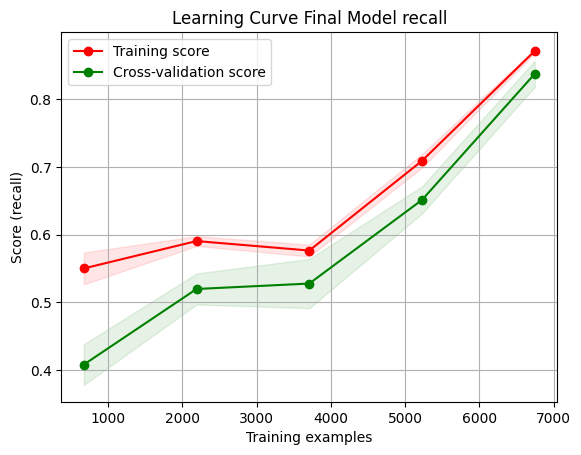

In [36]:
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(rf, X_train_res_pca_df, y_train_res, cv=cv, scoring='recall')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve Final Model recall")
plt.xlabel("Training examples")
plt.ylabel("Score (recall)")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

- Jika kurva skor pelatihan berada jauh di atas kurva skor validasi, ini bisa menjadi indikasi overfitting. Model sangat baik dalam memprediksi data pelatihan tetapi tidak bisa menggeneralisasi pada data baru (validasi), tapi Pada grafik, kita tidak melihat perbedaan yang sangat besar antara kurva pelatihan dan validasi pada bagian akhir. Meskipun skor pelatihan sedikit lebih tinggi, ini adalah hal yang wajar.

- Tidak ada indikasi kuat dari overfitting atau underfitting pada grafik ini.